# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import r2_score
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

sklearn.__version__

'1.0'

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y_Dwsce'#'y_wsce'
treatment = 'redufl'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
log_outcome=False
cross_val_cache = "data/cross-val-all.pkl"
bootstrap_cache = "data/bootstrap-all.pkl"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv("all_vars.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(data, treatment, outcome)
if log_outcome:
    data[outcome] = np.log(data[outcome]+data[outcome].min())

Dropped 592 rows missing treatment or outcome.


### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ), 
        Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
              parameters = {
                'max_features':[10,20,40,60,80],
                'learning_rate':np.logspace(-3,0,10),
                'min_samples_leaf':np.logspace(0,3,10).astype(int)
              }
        ),
    ]
    return models

# def construct_models(): Used for quick testing
#     models = [
#         Model('Ridge',Ridge(),
#               parameters = {'alpha':np.logspace(1,4,2)},
#               importance_func=importance_from_coef
#         ),
#         Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
#               parameters = {
#                 'max_features':[10],
#                 'learning_rate':np.logspace(-3,0,2),
#               }
#         ), 
#     ]
#     return models

### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Control data dimensions:  (3659, 638)
Treated data dimensions: (1295, 638)


### Compute unconditional/unadjusted estimate of treatment effect

In [6]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:26%
Average outcome under Control:67.85±15.36
Average outcome under Treatment:310.57±29.39
Unadjusted treatment estimate 242.72


### Propensity model

- Run primarily to check for violations over overlap assumptions.

In [7]:
from reed import visualise_propensity_model_performance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

X_train, X_test, t_train, t_test = train_test_split(X,t,stratify=t)
pmodel = LogisticRegressionCV(Cs = np.logspace(-5,-1,20), penalty='l2', max_iter=10000)
pmodel.fit(X_train, t_train);

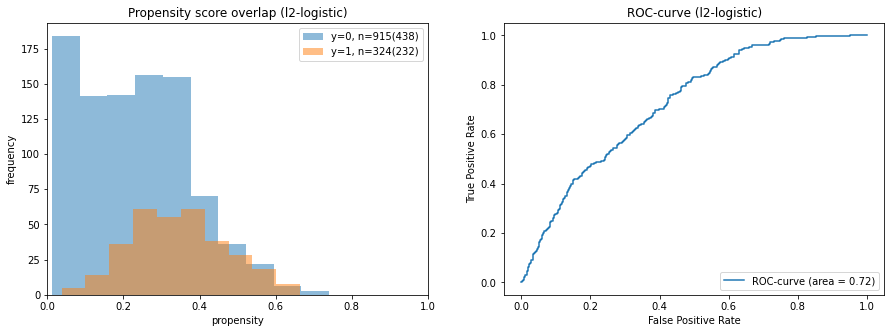

In [8]:
visualise_propensity_model_performance(t_test, pmodel.predict_proba(X_test)[:,1],'l2-logistic',bins=10)

In [9]:
def propensity_coefficients(model, features):
    if hasattr(model,'best_estimator_'):
        model = model.best_estimator_
    coef = model.coef_[0]
    
    with open('data/metadata.pkl','rb') as f:
        meta = pickle.load(f)
        labels = [meta.column_names_to_labels.get(f) for f in features]
    return pd.DataFrame({'label': labels, "c":coef,'abs':np.abs(coef)},index=features).sort_values(by='abs',ascending=False).head(50)
print("Propensity Model Coefficients")      
propensity_coefficients(pmodel, features).head(20)

Propensity Model Coefficients


,label,c,abs
aedq524,DV: ASCED 524 Certificate level I - Number of qualifications obtained since leaving school,0.060217,0.060217
ahgyob,HF4 Year of Birth,0.059439,0.059439
aicage1,H25 Check age,-0.053642,0.053642
aedqenr,C6 Ever enrolled in a course of study to obtain a qualification,-0.053514,0.053514
afibcar,SCQ:C7d Alright to borrow for - Car,-0.048970,0.048970
ajbocct,DV: Tenure in current occupation (years),-0.048008,0.048008
aedq521,DV: ASCED 521 Certificate level II - Number of qualifications obtained since leaving school,0.047771,0.047771
ahgage1,DV: Age last birthday at June 30 2001 - person 01,-0.044528,0.044528
aehtjb,DV: Time in paid work - years,-0.041492,0.041492
aioinflu,Z2 Influence respondent answers,-0.041471,0.041471


### (Nested) cross-validate to evaluate model performance
![image.png](images/nested_cross_val.png)

In [10]:
from direct_regression import nested_cross_val
models0, models1, results = nested_cross_val(
    construct_models,
    cross_val_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=10,
    load_from_cache=False
)

Fitting ridge ...Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Done
Fitting lasso ...Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.422e+07, tolerance: 7.775e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.305e+07, tolerance: 7.775e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.699e+07, tolerance: 9.031e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.005e+07, tolerance: 8.023e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.672e+05, tolerance: 3.819e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.500e+05, tolerance: 2.281e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.572e+05, tolerance: 4.900e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.854e+05, tolerance: 4.900e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.566e+04, tolerance: 3.455e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e+06, tolerance: 4.900e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Done
Fitting gbr ...Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Done
Caching results to data/cross-val-all_tmp.pkl


### Report estimate ATE and model performance

  - Mean and Std of prediction performance for each model (both treatment & control surface)
  - Mean and Std of average treatment effect for each model

,ACE,ACE_std,control_r2,control_r2_std,treated_r2,treated_r2_std,control_neg_mean_squared_error,control_neg_mean_squared_error_std,treated_neg_mean_squared_error,treated_neg_mean_squared_error_std
ridge,36.94,60.23,0.17,0.01,0.16,0.01,"-719,855.22","50,666.45","-936,783.97","153,615.53"
lasso,36.18,40.38,0.17,0.00,0.22,0.02,"-718,645.26","52,737.75","-878,889.35","158,576.82"
gbr,31.18,16.49,0.23,0.02,0.16,0.02,"-663,016.14","31,305.68","-938,736.52","166,442.31"


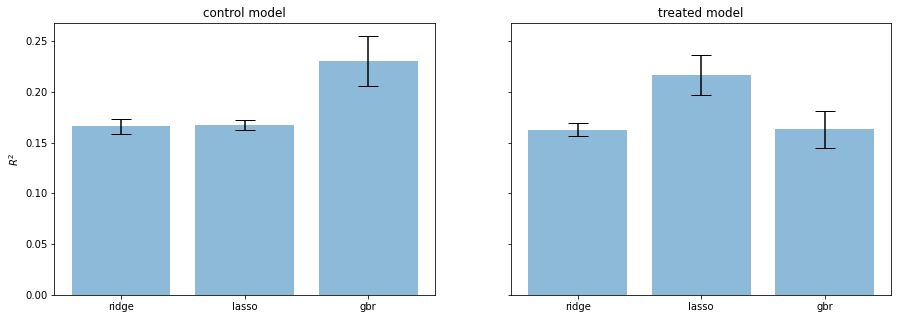

In [11]:
from direct_regression import visualise_ate
visualise_ate(results,X,evaluation_metrics);

### Visualise models
- Features responsible for treatment effect heterogeneity & functional form (with uncertainty)
      - coefficeints for linear models
      - TODO permutation importance & partial dependence curves for non-linear models

In [12]:
from direct_regression import display_feature_importance
display_feature_importance(models0, models1, results, features);

ridge


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
awscmei,61.025679,5.224179,-17.489227,77.006827,-69.770292,43.727593,-52.281065,33.279234
ahgyob,38.110123,1.388925,-0.679059,24.772482,37.770594,10.997316,38.449653,13.775166
aehtjb,34.969584,1.842772,1.485294,18.889178,-34.226937,7.601817,-35.712231,11.287362
ahiwscei,33.622736,2.958473,3.338218,52.671306,-31.953628,29.294125,-35.291845,23.377180
ahgage1,28.754137,3.034696,-3.973579,18.370024,-30.740927,12.219708,-26.767348,6.150316
awscmga,27.449938,7.569016,7.179738,60.395452,-23.860069,22.628710,-31.039807,37.766742
ahgage2,23.090565,2.168630,3.133032,18.485224,-21.524049,11.411242,-24.657081,7.073982
aicexpct,21.988948,2.630186,-12.672105,1.743572,15.652896,1.758400,28.325000,3.501972
aiclike,21.796787,3.218646,-5.051071,9.929065,19.271251,8.183179,24.322322,1.745886


lasso


,importance_mean,importance_std,Δcoef_mean,Δcoef_std,coef_treat_mean,coef_treat_std,coef_cntr_mean,coef_cntr_std
feature,,,,,,,,
ahgyob,247.492285,34.913801,130.463819,102.622093,312.724194,16.397246,182.260375,86.224847
awscmei,199.155892,10.141636,-122.186749,251.856678,-260.249266,136.069975,-138.062518,115.786703
aoifdiva,31.176951,44.090867,-62.353902,88.181733,-62.353902,88.181733,0.000000,0.000000
aicexpct,30.543307,9.545233,-61.086614,19.090465,0.000000,0.000000,61.086614,19.090465
acccinhh,30.202989,10.206796,47.708887,2.457194,-6.348545,8.978199,-54.057433,11.435393
arcage1,23.261894,7.610877,-31.663837,4.599017,-39.093812,5.311369,-7.429975,9.910385
aedqobd,17.466820,21.981485,31.086514,49.403626,31.086514,49.403626,0.000000,0.000000
ajbmpgj,17.076641,17.210102,-34.153282,34.420204,0.000000,0.000000,34.153282,34.420204
ancany,14.994848,8.393056,-7.482625,15.043692,11.253535,15.914902,18.736160,0.871210


### Compare against OLS on basic variables

In [13]:
basic = pd.read_csv("basic_variables.csv",index_col='xwaveid')
drop_missing_treatment_or_outcome(basic, treatment, outcome)
if log_outcome:
    basic[outcome] = np.log(basic[outcome]+basic[outcome].min())
    
X0b, X1b, y0b, y1b, Xb, yb, tb, featuresb = seperate_and_transform_data(basic, treatment, outcome)

def construct_basic_model():
    models = [
        Model('OLS',LinearRegression(),importance_func=importance_from_coef)
    ]
    return models

modelsb0, modelsb1, resultsb = nested_cross_val(
    construct_basic_model,
    "data/tmp.pkl",
    X0b, X1b, y0b, y1b,
    optimisation_metric,
    evaluation_metrics,
    innercv=5,
    outercv=10,
    load_from_cache=False)

Dropped 592 rows missing treatment or outcome.
Fitting OLS ...Done
Caching results to data/tmp.pkl


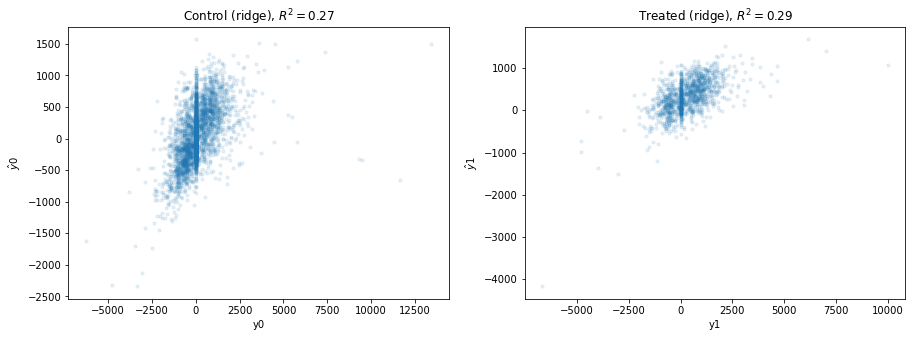

In [14]:
y0a = results['ridge'][0]['estimator'][1].predict(X0)
y1a = results['ridge'][1]['estimator'][1].predict(X1)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0a,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (ridge), $R^2={r2_score(y0,y0a):.2f}$')

ax[1].scatter(y1, y1a,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (ridge), $R^2={r2_score(y1,y1a):.2f}$');

# think about why these r2 scores are higher than on the holdout set (and whether they are likely overfitting)

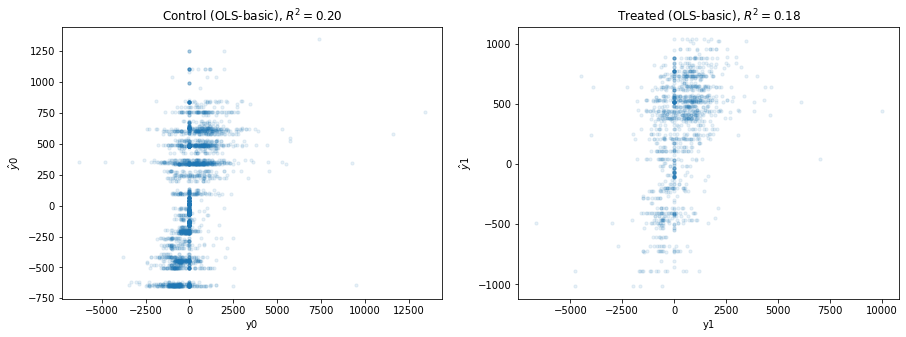

In [15]:
from sklearn.metrics import r2_score
y0b = resultsb['OLS'][0]['estimator'][0].predict(X0b)
y1b = resultsb['OLS'][1]['estimator'][0].predict(X1b)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y0, y0b,s=10,alpha=0.1)
ax[0].set_xlabel('y0')
ax[0].set_ylabel('$\\hat{y}0$');
ax[0].set_title(f'Control (OLS-basic), $R^2={r2_score(y0,y0b):.2f}$')

ax[1].scatter(y1, y1b,s=10,alpha=0.1)
ax[1].set_xlabel('y1')
ax[1].set_ylabel('$\\hat{y}1$');
ax[1].set_title(f'Treated (OLS-basic), $R^2={r2_score(y1,y1b):.2f}$');


### Bootstraped cross-validation to estimate parameter uncertainty
![image.png](images/bootstrap_validation.png)

In [16]:
from direct_regression import bootstrapped_cross_val
def extract_params(estimator):
    return estimator.coef_

bootstrap_results = bootstrapped_cross_val(
    construct_models,
    bootstrap_cache,
    X0, X1, y0, y1,
    optimisation_metric,
    extract_params,
    inner_cv=5,
    load_from_cache=False,
    samples=50
)

Fitting ridge ...Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Done
Fitting lasso ...Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e+08, tolerance: 1.614e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e+08, tolerance: 1.614e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.248e+06, tolerance: 1.614e+05
  model = cd_fast.enet_coordinate_descent(


Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e+08, tolerance: 1.508e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+08, tolerance: 1.508e+05
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.061e+06, tolerance: 6.483e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e+06, tolerance: 8.159e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Fitting 2 folds for each of 30 candidates, totalling 60 fits


/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e+06, tolerance: 5.484e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.321e+05, tolerance: 5.484e+04
  model = cd_fast.enet_coordinate_descent(
/home/finn/miniconda3/envs/reed/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasi

Done
Fitting gbr ...Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Fitting 2 folds for each of 500 candidates, totalling 1000 fits
Done
Total time:154.19736099243164 seconds
Caching results to: data/bootstrap-all_tmp.pkl


####  Average treatment effects

In [17]:
from direct_regression import compute_ate
compute_ate(bootstrap_results,X)

,ACE,ACE_std
ridge,67.636699,34.002646
lasso,75.199207,37.067739
gbr,17.558958,37.937182


#### Distribution of hyper-parameters

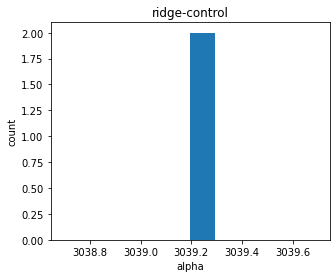

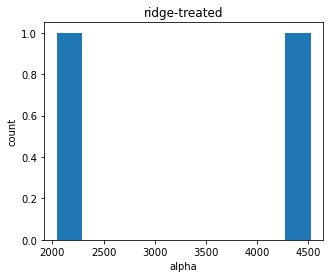

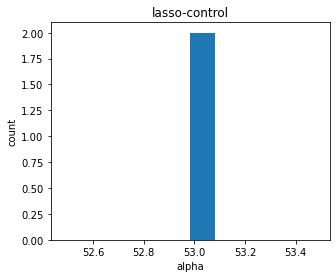

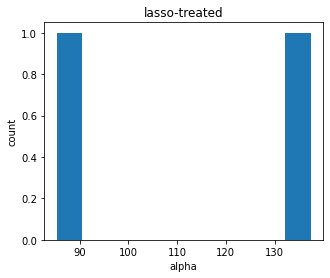

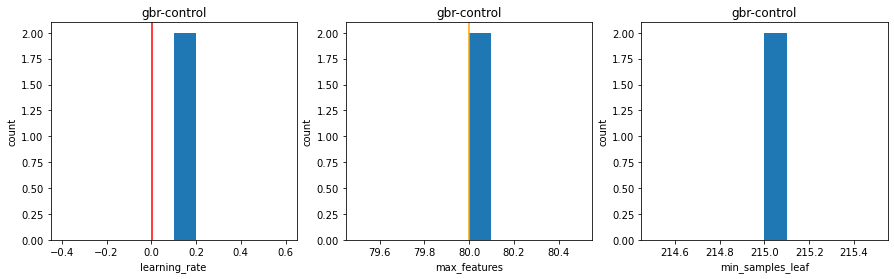

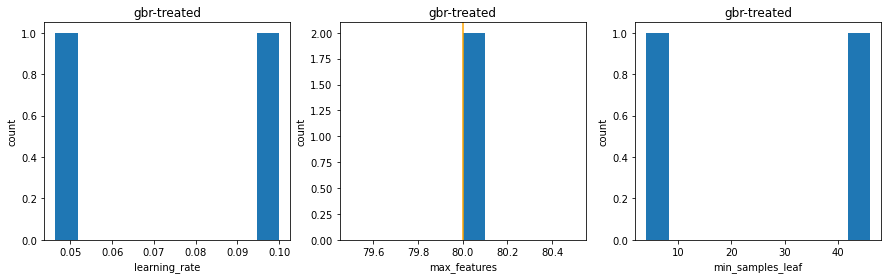

In [18]:
from direct_regression import plot_hyperparam_distributions
for model, (results0, results1) in bootstrap_results.items():
    plot_hyperparam_distributions(results0,f"{model}-control")
    plot_hyperparam_distributions(results1,f"{model}-treated")